# eQTL Analysis

In [1]:
import copy
import glob
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'eqtl_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)
dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
h2 = pd.read_table(os.path.join(dy, 'h2.tsv'), index_col=0, squeeze=True, header=None)
dy = os.path.join(ciepy.root, 'output/eqtl_processing/no_peer01')
h2_no_peer = pd.read_table(os.path.join(dy, 'h2.tsv'), index_col=0, squeeze=True, header=None)

gold_eqtls = pd.read_table(
    os.path.join(ciepy.root, 'output', 'eqtl_methods_exploration', 'gold_eqtls.tsv'),
    index_col=0)

fn = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls02', 'lead_variants.tsv')
lead_vars_second = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls03', 'lead_variants.tsv')
lead_vars_third = pd.read_table(fn, index_col=0)

## Summary

In [3]:
print('We detected eQTLs for {:,.0f} of {:,} genes tested.'.format(qvalues.perm_sig.sum(), 
                                                                   qvalues.shape[0]))

We detected eQTLs for 5,619 of 17,819 genes tested.


In [4]:
for i in range(1, 4):
    fn = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls0{}/qvalues.tsv'.format(i))
    tdf = pd.read_table(fn, index_col=0)
    print('{:,.0f} of {:,} significant genes have eQTLs for analysis {}.'.format(
            tdf.perm_sig.sum(), tdf.shape[0], i))

5,619 of 17,819 significant genes have eQTLs for analysis 1.
668 of 5,619 significant genes have eQTLs for analysis 2.
201 of 668 significant genes have eQTLs for analysis 3.


In [5]:
print('Number of genes with variant type as lead variant (ties allowed):')
s = set(lead_vars[lead_vars.perm_sig].gene_id + ':' + lead_vars[lead_vars.perm_sig].variant_type)
pd.Series([x.split(':')[1] for x in s]).value_counts()

Number of genes with variant type as lead variant (ties allowed):


snv    4892
del     731
ins     615
cnv     111
dtype: int64

In [6]:
731 + 615

1346

In [7]:
print('Number of genes with lead variant from each caller (ties allowed):')
s = set(lead_vars[lead_vars.perm_sig].gene_id + ':' + lead_vars[lead_vars.perm_sig].variant_caller)
pd.Series([x.split(':')[1] for x in s]).value_counts()

Number of genes with lead variant from each caller (ties allowed):


gatk           5517
genomestrip      95
lumpy            17
dtype: int64

In [8]:
n = sum(gene_variant.marker_id.apply(lambda x: 'CNV' in x))
print('Total number of CNV eQTLs: {:,}'.format(n))

Total number of CNV eQTLs: 545


In [9]:
sig = lead_vars[lead_vars.perm_sig]
sig_single = lead_vars[lead_vars.perm_sig]

## Comparison to GTEx Multi-Tissue eQTLs

I want to visualize some of the permutation $p$-values versus the "real" $p$-value
for some of the GTEx multi-tissue eQTLs.

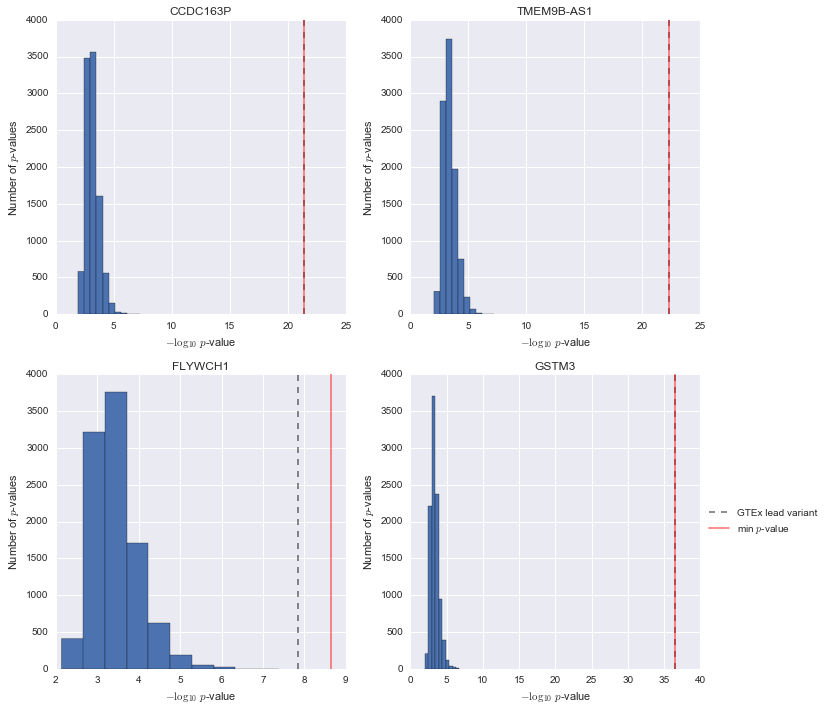

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, g in enumerate(list(set(sig.gene_id) & set(gold_eqtls.index))[0:4]):
    ax = axs[i]
    fn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01',
                      'gene_results', g, '{}.tsv'.format(g))
    min_fn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                          'gene_results', g, 'minimum_pvalues.tsv')
    if os.path.exists(min_fn):
        res = ciepy.read_emmax_output(fn)
        #t = res[res.MARKER_ID.apply(lambda x: gold_eqtls.ix[g, 'rsid'] in x)]
        t = res[res.BEG == gold_eqtls.ix[g, 'start']]
        min_pvals = pd.read_table(min_fn, header=None, squeeze=True)
        
        ax = (-np.log10(min_pvals)).hist(ax=ax)
        ax.set_ylabel('Number of $p$-values')
        ax.set_xlabel('$-\log_{10}$ $p$-value')
        ya, yb = ax.get_ylim()
        ax.vlines(-np.log10(t.PVALUE), ya, yb, label='GTEx lead variant', alpha=0.5, linestyle='--')
        ax.vlines(-np.log10(res.PVALUE.min()), ya, yb, colors=['red'], label='min $p$-value', alpha=0.5)
        ax.set_title('{}'.format(gene_info.ix[g, 'gene_name']));
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'gtex_comparison.pdf'), 
            bbox_extra_artists=(lgd,), bbox_inches='tight')

The black line shows the $p$-value for the GTEx SNV. The red line shows the smallest $p$-value that
I observe for the gene. We can see that most of these genes are highly significant compared to the 
permutation $p$-values.

## Distance to Nearest TSS

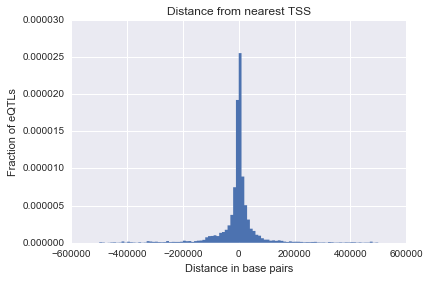

In [11]:
n,b,p = plt.hist(sig.tss_dist, 
                 bins=np.arange(-500000, 510000, 10000),
                 normed=True, histtype='stepfilled',
                 linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

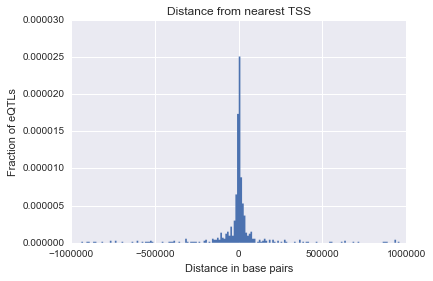

In [12]:
n,b,p = plt.hist(sig[sig.variant_type == 'ins'].tss_dist, 
                 bins=np.arange(-1000000, 1010000, 10000),
                 normed=True, histtype='stepfilled', linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

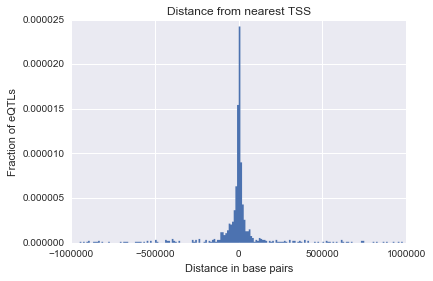

In [13]:
n,b,p = plt.hist(sig[sig.variant_type == 'del'].tss_dist, 
                 bins=np.arange(-1000000, 1010000, 10000),
                 normed=True, histtype='stepfilled', linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

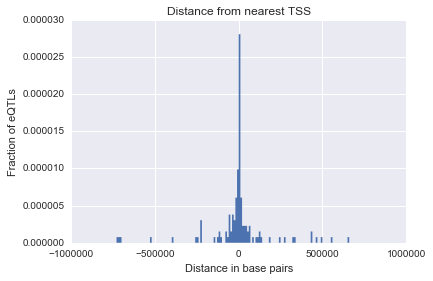

In [14]:
n,b,p = plt.hist(sig[sig.variant_type == 'cnv'].tss_dist, 
                 bins=np.arange(-1000000, 1010000, 10000),
                 normed=True, histtype='stepfilled', linewidth=0)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

The above two plots are the same data at different $x$-axis limits. The first plot
in particular is meant to be comparable to Fig. S9 from the GTEx paper.

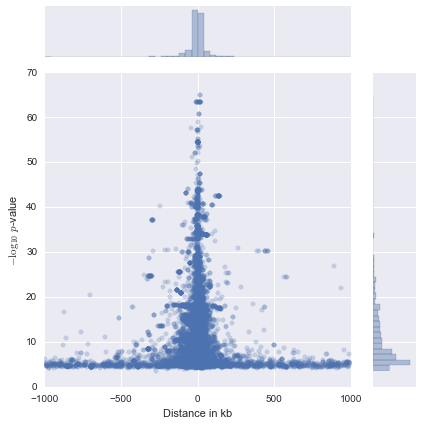

In [15]:
ax = sns.jointplot(sig_single.tss_dist / 1000,
                   -np.log10(sig_single.pvalue),
                   stat_func=None, alpha=0.25)
ax.set_axis_labels(xlabel='Distance in kb',
                   ylabel='$-\log_{10}$ $p$-value')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_pvalue_tss_dist.pdf'))

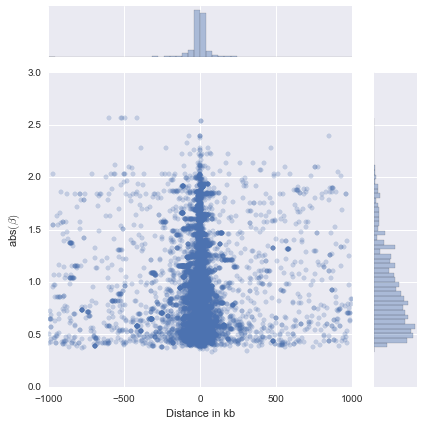

In [16]:
ax = sns.jointplot(sig_single.tss_dist / 1000,
                   sig_single.beta.abs(),
                   stat_func=None, alpha=0.25)
ax.set_axis_labels(xlabel='Distance in kb', ylabel='abs$(\\beta)$')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_beta_tss_dist.pdf'))

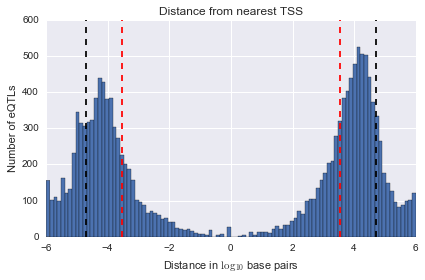

In [17]:
dists = sig_single.tss_dist
a = dists[dists >= 0]
b = -dists[dists < 0]
r = plt.hist(list(np.log10(a + 1)) + list(-np.log10(b + 1)),
             bins=100)
plt.title('Distance from nearest TSS')
plt.ylabel('Number of eQTLs')
plt.xlabel('Distance in $\log_{10}$ base pairs')
ya, yb = plt.ylim()
plt.vlines(np.log10(50000), ya, yb, linestyles='--')
plt.vlines(-np.log10(50000), ya, yb, linestyles='--')
plt.vlines(np.log10(3500), ya, yb, linestyles='--', color='red')
plt.vlines(-np.log10(3500), ya, yb, linestyles='--', color='red')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_snv_tss_log_dist.pdf'))

Grubert et al. defined distal as greater than 50 kb away (outside of the black lines above). 
They searched for *cis* QTLs within 2kb of peak boundaries or $\pm$3.5kb around the TSS (inside
of the red lines above). I'd like to go back and see what they thought about the intermediate region.

I'm somewhat surprised that there are more potential QTNs downstream of TSSs. In the plot, a positive 
distance indicates that the SNV is downstream of the TSS (relative to the strand of the TSS) although
I believe this has been reported before (I think it was a PLOS Genetics paper that estimated where
causal variants were located and found that they were estimated to be slightly downstream of the TSS).

## Gencode Gene Type

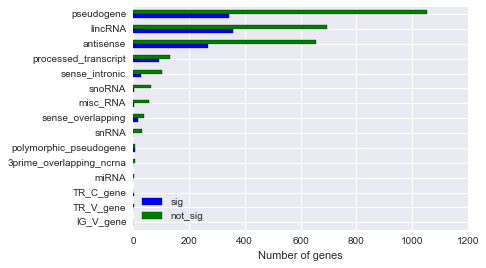

In [18]:
t = pd.DataFrame(0, index=set(gene_info.gene_type), columns=['sig', 'not_sig'])
vc = gene_info.ix[qvalues[qvalues.perm_sig].index, 'gene_type'].value_counts()
t.ix[vc.index, 'sig'] = vc
vc = gene_info.ix[qvalues[qvalues.perm_sig == False].index, 'gene_type'].value_counts()
t.ix[vc.index, 'not_sig'] = vc
t = t[t.sum(axis=1) > 1]
t['total'] = t.sum(axis=1)
#t.sort_values(by='total', inplace=True, ascending=False)
t.sort_values(by='total', inplace=True)
t.drop('protein_coding')[['sig', 'not_sig']].plot(kind='barh')
plt.xlabel('Number of genes');

## Manhattan and Expression Plots

In [19]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

qvalue_sig = qvalues[qvalues.perm_sig == 1]
qvalue_sig = qvalue_sig.sort_values('perm_qvalue')

In [20]:
def eqtl_summary(gene_id, left=None, right=None, fn_root=None):
    res = ciepy.read_emmax_output(res_fns[gene_id])
    res = res.sort_values('PVALUE')
    ind = sig_single[sig_single.gene_id == gene_id].index[0]
    if gene_info.ix[gene_id, 'strand'] == '+':
        gene_left = gene_info.ix[gene_id, 'start']
        gene_right = gene_info.ix[gene_id, 'end']
    else:
        gene_right = gene_info.ix[gene_id, 'start']
        gene_left = gene_info.ix[gene_id, 'end']
    if left:
        res = res[res.BEG >= gene_left - left]
    if right:
        res = res[res.BEG <= gene_right + right]
    plt.figure()
    plt.scatter(res.BEG, -np.log10(res.PVALUE), color='grey', alpha=0.5)
    plt.xlim(res.BEG.min(), res.BEG.max())
    ya = 0
    yb = (-np.log10(res.PVALUE)).max() + 1
    plt.ylim(ya, yb)
#     plt.vlines(most_sig_single.ix[g, 'tss_start'], ya, yb, color='blue',
#                linestyles='--', alpha=0.5)
    poly = plt.Polygon([[gene_left, 0.9 * yb], [gene_left, yb], [gene_right, 0.95 * yb]], 
                       closed=True, facecolor='blue', edgecolor='none')
    plt.gca().add_patch(poly)
    #most_sig_single.ix[g, 'tss_start']
    plt.xlabel('Genomic position')
    plt.ylabel('$-\log_{10}$ $p$-value')
    plt.title('Manhattan plot for {}'.format(gene_info.ix[gene_id, 'gene_name']));
    if fn_root:
        plt.tight_layout()
        plt.savefig('{}_manhattan.pdf'.format(fn_root))
        
    t =  vcf_reader.fetch(res.CHROM.values[0], 
                          res.BEG.values[0], 
                          res.BEG.values[0] + 1)
    r = t.next()
    tdf = pd.DataFrame(exp.ix[gene_id])
    tdf.columns = ['expression']
    tdf['genotype'] = 0
    hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
    tdf.ix[hets, 'genotype'] = 1
    alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
    tdf.ix[alts, 'genotype'] = 2
    plt.figure()
    #sns.lmplot(x='genotype', y='expression', data=tdf)
    ax = sns.violinplot(x='genotype', y='expression', data=tdf, color='grey',
                    order=[0, 1, 2], scale='count')
    sns.regplot(x='genotype', y='expression', data=tdf, scatter=False, color='red')
    ya, yb = plt.ylim()
    plt.text(0, yb, 'n={}'.format(sum(tdf.genotype == 0)), 
             verticalalignment='top', horizontalalignment='center')
    plt.text(1, yb, 'n={}'.format(sum(tdf.genotype == 1)), 
             verticalalignment='top', horizontalalignment='center')
    plt.text(2, yb, 'n={}'.format(sum(tdf.genotype == 2)), 
             verticalalignment='top', horizontalalignment='center')
    plt.title('Expression vs. genotype for {}'.format(gene_info.ix[gene_id, 'gene_name']));
    if fn_root:
        plt.tight_layout()
        plt.savefig('{}_violin.pdf'.format(fn_root))

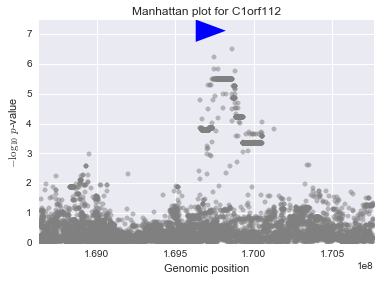

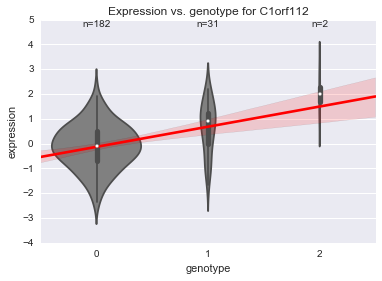

In [21]:
eqtl_summary(sig.gene_id[0])

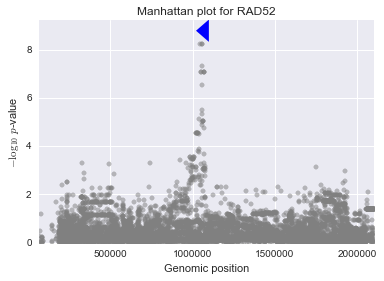

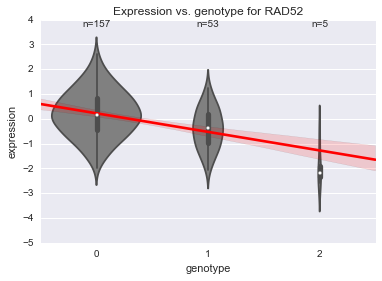

In [22]:
eqtl_summary(sig.gene_id[5])

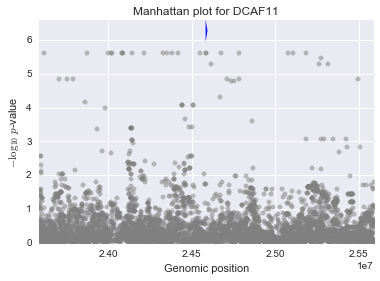

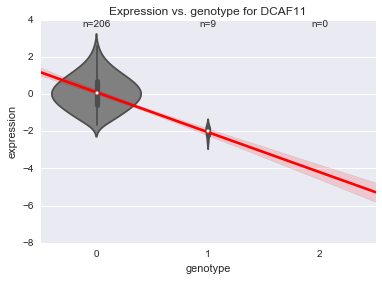

In [23]:
eqtl_summary('ENSG00000100897.13')

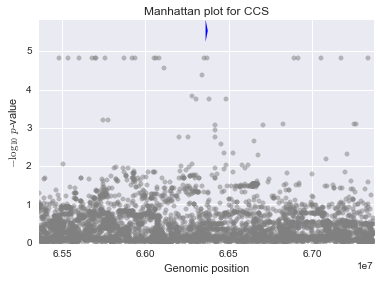

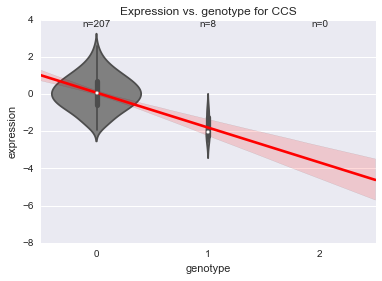

In [24]:
eqtl_summary('ENSG00000173992.4')

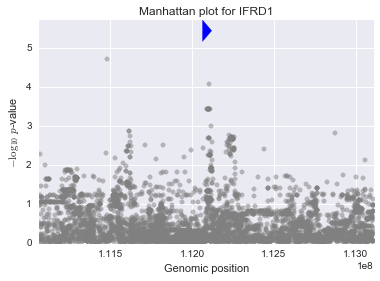

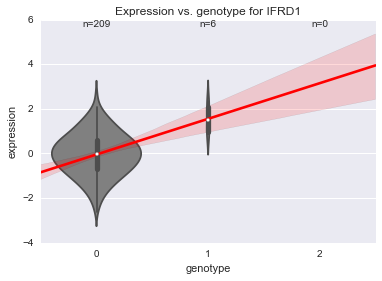

In [25]:
eqtl_summary('ENSG00000006652.9')

## Pluripotency Genes

In [26]:
fn = os.path.join(ciepy.root, 'misc', 'stem_cell_population_maintenance.tsv')
a = pd.read_table(fn, header=None)
fn = os.path.join(ciepy.root, 'misc', 'regulation_of_stem_cell_population_maintenance.tsv')
b = pd.read_table(fn, header=None)
go_genes = set(a[2]) | set(b[2])
go_genes = go_genes & set(gene_info.gene_name)

n = len(set(a[2]) & set(gene_info.ix[qvalues[qvalues.perm_sig].index, 'gene_name']))
print('{} eGenes of {} from stem cell population maintenance.'.format(n, a.shape[0]))
n = len(set(b[2]) & set(gene_info.ix[qvalues[qvalues.perm_sig].index, 'gene_name']))
print('{} eGenes of {} from regulation of stem cell population maintenance.'.format(n, b.shape[0]))
n = len(set(a[2]) & set(b[2]) & set(gene_info.ix[qvalues[qvalues.perm_sig].index, 'gene_name']))
print('{} eGenes shared.'.format(n))

35 eGenes of 191 from stem cell population maintenance.
4 eGenes of 25 from regulation of stem cell population maintenance.
4 eGenes shared.


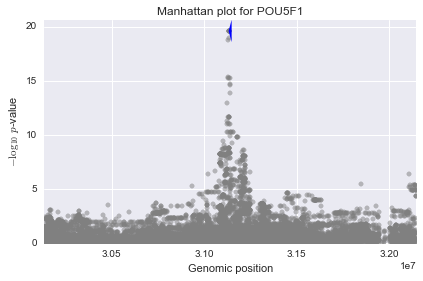

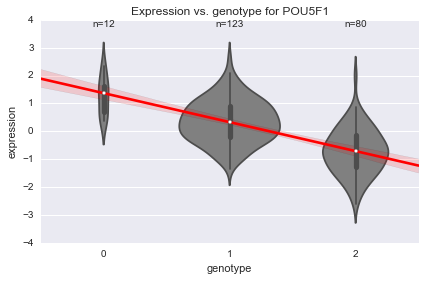

In [27]:
pgenes = ['LIN28A', 'POU5F1', 'SOX2', 'NANOG', 'MYC', 'KLF4', 'ZFP42']
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in sig.gene_id.values:
        eqtl_summary(i, fn_root=os.path.join(outdir, '{}_summary'.format(g)))

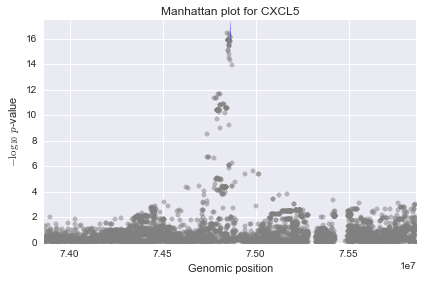

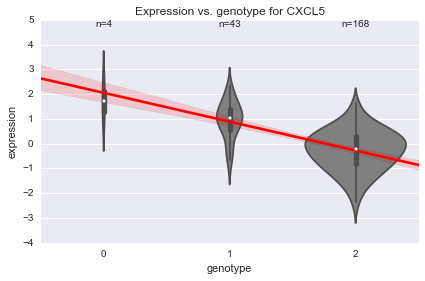

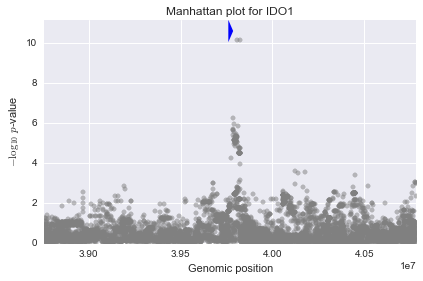

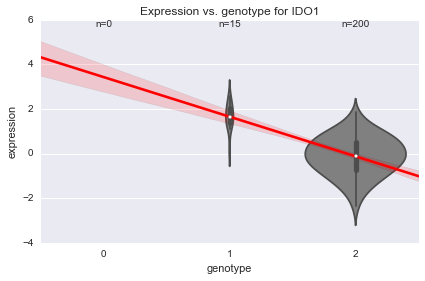

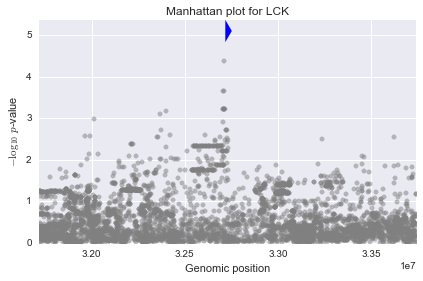

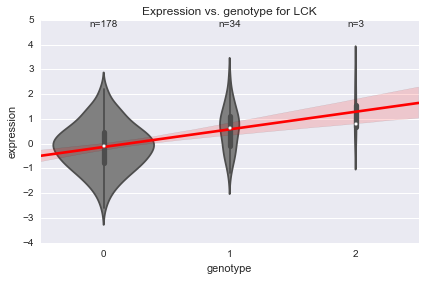

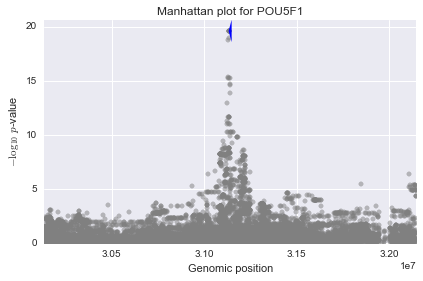

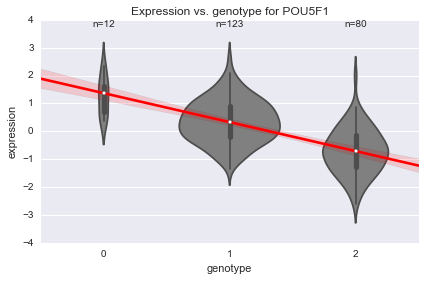

In [28]:
# Markers of pluripotency from http://www.nature.com/nbt/journal/v33/n11/full/nbt.3387.html.
pgenes = ['CXCL5', 'IDO1', 'LCK', 'TRIM22', 'DNMT3B', 'HESX1', 'SOX2', 'POU5F1', 'NANOG']
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in sig.gene_id.values:
        eqtl_summary(i, fn_root=os.path.join(outdir, '{}_summary'.format(g)))

In [29]:
genes = [u'BRIX1 ', u'CD9', u'COMMD3 ', u'CRABP2 ', u'CXCL5', u'DIAPH2',
         u'DNMT3B', u'EDNRB ', u'FGF4 ', u'FGF5 ', u'FOXD3 ', u'GABRB3 ',
         u'GAL ', u'GBX2', u'GDF3 ', u'GRB7 ', u'HCK ', u'HESX1', u'IDO1',
         u'IFITM1 ', u'IFITM2', u'IGF2BP2', u'IL6ST ', u'KIT ', u'LCK', u'LIFR ',
         u'LIN28A', u'NANOG', u'NODAL ', u'NOG', u'NR5A2', u'NR6A1', u'PODXL',
         u'POU5F1', u'PTEN ', u'SEMA3A', u'SFRP2 ', u'SOX2', u'TDGF1', u'TERT',
         u'TFCP2L1', u'TRIM22', u'UTF1', u'ZFP42']
for g in genes:
    if g in gene_info.gene_name.values:
        i = gene_info[gene_info.gene_name == g].index[0]
        if i in sig.gene_id:
            eqtl_summary(i)#, fn_root=os.path.join(outdir, '{}_summary'.format(g)))

In [30]:
pgenes = ['LIN28A', 'POU5F1', 'SOX2', 'NANOG', 'MYC', 'KLF4', 'ZFP42']
t = set(lead_vars_second.ix[lead_vars_second.perm_sig, 'gene_name'])
for g in pgenes:
    if g in t:
        print(g)

POU5F1


*POU5F1* has a second eQTL as well.

In [31]:
def ld_vs_pval(gene_id):
    ind = lead_vars_single[lead_vars_single.gene_id == gene_id].index[0]
    fn = '/publicdata/1KGP_20151103/LD/tabix/{}_EUR_ld_all.hap.ld.bed.gz'.format(sig_single.ix[ind, 'chrom'])
    c = 'tabix {} {}:{}-{}'.format(fn, lead_vars_single.ix[ind].chrom,
                                   sig_single.ix[ind].start - 1, sig_single.ix[ind].end)
    res = subprocess.check_output(c, shell=True)
    tdf = pd.DataFrame([x.split() for x in res.strip().split('\n')],
                       columns=['chrom', 'start', 'end', 'ld_info'])
    se = pd.Series(tdf['ld_info'].apply(lambda x: x.split(':')).apply(lambda x: x[2]).values,
                   index=tdf['ld_info'].apply(lambda x: x.split(':')).apply(lambda x: x[1])).astype(float)

    res = ciepy.read_emmax_output(res_fns[gene_id])
    res.index = res.BEG.astype(str)
    plt.scatter(se.values, -np.log10(res.ix[se.index, 'PVALUE'].values), 
                color='grey', alpha=0.5, s=100)
    xa, xb = plt.xlim()
    plt.hlines(-np.log10(lead_vars_single.ix[ind, 'pvalue']), xa, xb,
               color='red', linestyle='--')
    plt.xlim(xa, xb)
    plt.ylabel('$-\log_{10}$ $p$-value')
    plt.xlabel('LD with most significant SNV');

## Pseudoheritability

### Regular eQTL

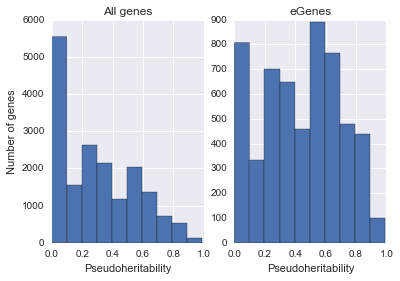

In [33]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
h2.hist(ax=ax)
ax.set_title('All genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Pseudoheritability')
ax = axs[1]
h2[qvalues[qvalues.perm_sig].index].hist(ax=ax)
ax.set_xlabel('Pseudoheritability')
ax.set_title('eGenes');

In [34]:
a = h2.mean()
b = h2[qvalues[qvalues.perm_sig].index].mean()
print('The average pseudoheritability for all genes is {:.2f}% '
      'and for significant genes is {:.2f}% for residual gene '
      'expression.'.format(a * 100, b * 100))

The average pseudoheritability for all genes is 29.63% and for significant genes is 43.47% for residual gene expression.


### No PEER factors

I thought that perhaps the PEER factors may have removed some variation
that was due to genetics, so I ran EMMAX using a covariate file that has
age and flowcell ID and I used the expression values before PEER.

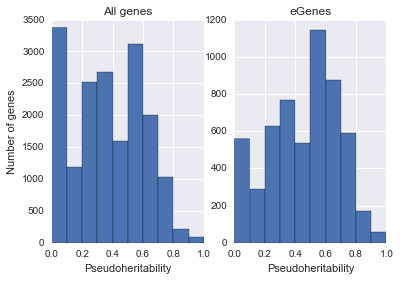

In [35]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
h2_no_peer.hist(ax=ax)
ax.set_title('All genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Pseudoheritability')
ax = axs[1]
h2_no_peer[qvalues[qvalues.perm_sig].index].hist(ax=ax)
ax.set_xlabel('Pseudoheritability')
ax.set_title('eGenes');

In [36]:
a = h2_no_peer.mean()
b = h2_no_peer[qvalues[qvalues.perm_sig].index].mean()
print('The average pseudoheritability for all genes is {:.2f}% '
      'and for significant genes is {:.2f}% for gene '
      'expression using flow cell, age, and sex as covariates.'.format(a * 100, b * 100))

The average pseudoheritability for all genes is 36.42% and for significant genes is 45.01% for gene expression using flow cell, age, and sex as covariates.
